# PyTorch を利用した実装（畳み込みニューラルネットワーク）

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/hseiyama/DeepLearning/blob/main/pytorch_basic_02_cnn.ipynb)

In [40]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

### パラメータの定義

In [41]:
epoch_num = 20  # エポック数を設定する
batch_size = 100  # バッチの数
learning_rate = 0.1  # 学習係数

### MNIST データセット

In [42]:
# 訓練データをdatasetsからダウンロード
training_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

# テストデータをdatasetsからダウンロード
test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

### データローダー

In [43]:
# データローダーの作成
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print('X.shape [N, C, H, W]:', X.shape)
    print('y.shape:', y.shape, y.dtype)
    break

X.shape [N, C, H, W]: torch.Size([100, 1, 28, 28])
y.shape: torch.Size([100]) torch.int64


#### 【オプション】入力データの確認

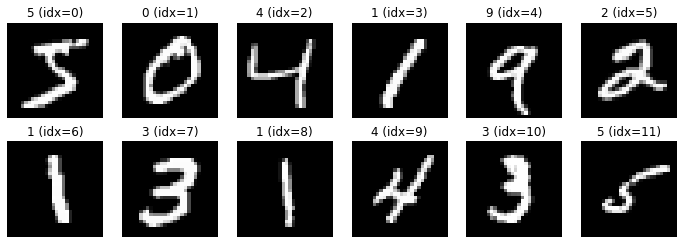

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5])


In [44]:
for X, y in train_dataloader:
    x_train = X
    t_train = y
    break

# 画像を表示
figure = plt.figure(figsize=(12, 4))
rows, cols = 2, 6
for i in range(rows * cols):
    img, label = x_train[i], t_train[i]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f'{label} (idx={i})')
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')  # 1x28x28 -> 28x28 に変換
plt.show()
print(y[:rows * cols])

### ニューラルネットワークの定義

In [45]:
# modelを定義します
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Sequential(
            # 畳み込み層（入力チャンネル数、フィルタ数、フィルタサイズ、ストライド、パディング）
            nn.Conv2d(1, 30, kernel_size=5, stride=1, padding=0),  # (batch)x1x28x28 -> (batch)x30x24x24
            nn.ReLU(),
            # プーリング層（領域のサイズ、ストライド、パディング）
            nn.MaxPool2d(2, stride=2, padding=0))  # (batch)x30x24x24 -> (batch)x30x12x12
        self.layer2 = nn.Sequential(
            nn.Flatten(),  # (batch)x30x12x12 -> (batch)x(30*12*12) に変換
            nn.Linear(30*12*12, 100),  # 全結合層 (batch)x(30*12*12) -> (batch)x100
            nn.ReLU())
        self.layer3 = nn.Linear(100, 10)  # 全結合層 (batch)x100-> (batch)x10

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

### ニューラルネットワークのインスタンス化

In [46]:
# 訓練に際して、可能であればGPU（cuda）を設定します。GPUが搭載されていない場合はCPUを使用します
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(1, 30, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4320, out_features=100, bias=True)
    (2): ReLU()
  )
  (layer3): Linear(in_features=100, out_features=10, bias=True)
)


### 損失関数と最適化手法を定義

In [47]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### 訓練のプロセス

In [48]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()  # 訓練モード
    loss_list = []
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        #y = torch.eye(10)[y]  # index -> one-hot 形式に変換
        
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        print(f'\rtrain batch({batch + 1})', end='')
    
    return loss_list

### 評価のプロセス

In [49]:
def test(dataloader, model, title):
    model.eval()  # 評価モード
    correct = 0
    size = len(dataloader.dataset)
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            print(f'\rtest({title}) batch({batch + 1}){" " * 5}', end='')
    correct /= size
    
    return correct

### ミニバッチの学習

In [50]:
train_loss_list = []
train_acc_list = [0.0]
test_acc_list = [0.0]

for t in range(epoch_num):
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    train_loss_list += train_loss
    print(f'\repoch({t + 1}) loss = {train_loss_list[-1]}')
    train_acc = test(train_dataloader, model, 'train_data')
    test_acc = test(test_dataloader, model, 'test_data')
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f'\repoch({t + 1}) accuracy(train, test) = ({train_acc}, {test_acc})')

print('Done!')

epoch(1) loss = 0.29971063137054443
epoch(1) accuracy(train, test) = (0.95605, 0.959)
epoch(2) loss = 0.2561866044998169
epoch(2) accuracy(train, test) = (0.9753833333333334, 0.976)
epoch(3) loss = 0.23108407855033875
epoch(3) accuracy(train, test) = (0.9824833333333334, 0.9814)
epoch(4) loss = 0.21561458706855774
epoch(4) accuracy(train, test) = (0.98605, 0.9839)
epoch(5) loss = 0.2062760293483734
epoch(5) accuracy(train, test) = (0.9886333333333334, 0.9853)
epoch(6) loss = 0.20143844187259674
epoch(6) accuracy(train, test) = (0.9906166666666667, 0.9865)
epoch(7) loss = 0.1968168318271637
epoch(7) accuracy(train, test) = (0.99205, 0.987)
epoch(8) loss = 0.19523963332176208
epoch(8) accuracy(train, test) = (0.9930666666666667, 0.9874)
epoch(9) loss = 0.19174480438232422
epoch(9) accuracy(train, test) = (0.9939166666666667, 0.9879)
epoch(10) loss = 0.19116181135177612
epoch(10) accuracy(train, test) = (0.9945833333333334, 0.9884)
epoch(11) loss = 0.1881883442401886
epoch(11) accuracy(tr

### 損失関数の推移

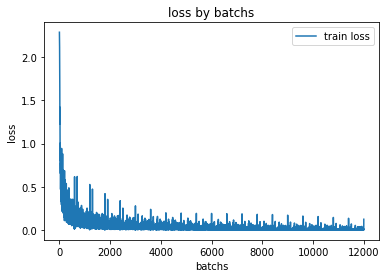

In [51]:
# グラフの描画
x = torch.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss')
plt.xlabel('batchs')
plt.ylabel('loss')
plt.title('loss by batchs')
plt.legend(loc='upper right')
plt.show()

### 認識精度の推移

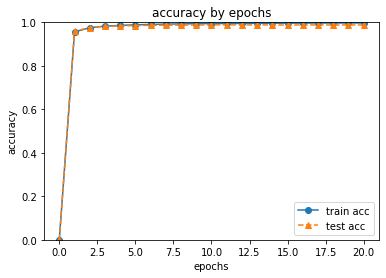

In [52]:
# グラフの描画
x = torch.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc', marker='o')
plt.plot(x, test_acc_list, label='test acc', linestyle='--', marker='^')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy by epochs')
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

#### 【オプション】テストの結果

In [53]:
x_test = None
t_test = None
test_predict = None

# テストの実行
model.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        X, y = X.to('cpu'), y.to('cpu')
        x_test = torch.cat((x_test,X),0) if x_test is not None else X
        t_test = torch.cat((t_test,y),0) if t_test is not None else y
        test_predict = torch.cat((test_predict,pred),0) if test_predict is not None else pred

print(test_predict.shape)
for index in range(3):
    print(f'index = {index}')
    print(test_predict[index])
    print(t_test[index])

torch.Size([10000, 10])
index = 0
tensor([ -3.1841,   1.5001,  -1.0304,   1.1418,  -5.6666,  -3.7650, -17.1057,
         18.3110,  -2.2297,   5.8947])
tensor(7)
index = 1
tensor([  6.8826,   7.5178,  25.0510,  -2.2651, -12.4428, -12.4484,  -0.6981,
         -6.8284,   1.1503,  -9.3200])
tensor(2)
index = 2
tensor([-3.7089, 13.6744, -1.8751, -8.9444,  4.5411, -3.5198, -3.4266,  1.8270,
         2.7402, -2.9957])
tensor(1)


#### 【オプション】エラー結果の確認

error rate = 1.2[%] (num = 120/10000)


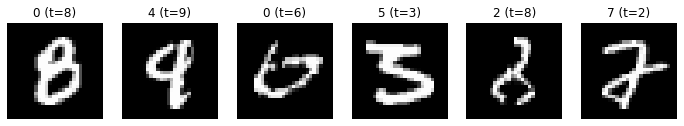

tensor([[ 11.5620,  -7.3894,   2.1042,  -2.6334,  -2.5495,  -3.8409,   3.3381,
          -5.5671,  10.3603,  -3.9397],
        [ -9.3104,  -3.8056,  -7.5775,  -2.7280,  15.3660,  -3.9476, -14.9943,
           0.3530,   7.0759,  14.6108],
        [ 16.3008, -10.1826,  -1.2089,  -7.0210,  -4.7604,   4.3233,  15.8187,
          -1.3771,  -2.9535,  -4.2961],
        [-18.5811,  -3.4570,  -6.1045,  20.1895, -10.4606,  24.7421,  -7.7719,
          -6.3195,  -0.4956,   0.9973],
        [ -3.6598,   0.6415,  15.8824,   7.9730,  -4.2917, -11.6988,  -8.4584,
          -0.0742,  12.4694,  -5.3099],
        [ -3.6865,  -0.6926,  17.8431,  11.3236, -12.0888, -20.5951, -18.9026,
          18.3024,  13.6926,  -2.2099]])


In [54]:
# エラー結果の要素を抽出
index_error = torch.argmax(test_predict, axis=1) != t_test
error_list = torch.arange(len(test_predict))[index_error]
print(f'error rate = {len(error_list) / len(test_predict) * 100}[%]',
      f'(num = {len(error_list)}/{len(test_predict)})')

offset = 0
# 画像を表示
figure = plt.figure(figsize=(12, 2))
rows, cols = 1, 6
for i in range(rows * cols):
    index = error_list[offset + i]
    img, label_t, label_y = x_test[index], t_test[index], test_predict[index].argmax()
    figure.add_subplot(rows, cols, i + 1)
    plt.title(f'{label_y} (t={label_t})')
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')  # 1x28x28 -> 28x28 に変換
plt.show()
print(test_predict[error_list[offset:offset + rows * cols]])